# Assignment 3: Logistic Regression and Disaster at Sea

By typing my name, I confirm that the code, experiments, results, and discussions are all written by me, except for the code provided by the instructor.  

*Ryan Blocker*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#50-points:-Code-Requirements" data-toc-modified-id="50-points:-Code-Requirements-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><font color="red"><strong>50 points</strong></font>: Code Requirements</a></span><ul class="toc-item"><li><span><a href="#class-LogisticRegression" data-toc-modified-id="class-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>class <code>LogisticRegression</code></a></span></li></ul></li><li><span><a href="#20-points:-Test-of-your-LogisticRegression-class" data-toc-modified-id="20-points:-Test-of-your-LogisticRegression-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><font color="red"><strong>20 points</strong></font>: Test of your <code>LogisticRegression</code> class</a></span></li><li><span><a href="#30-points:-Experiment-with-Titanic-Data" data-toc-modified-id="30-points:-Experiment-with-Titanic-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><font color="red"><strong>30 points</strong></font>: Experiment with Titanic Data</a></span><ul class="toc-item"><li><span><a href="#Download-and-read-the-data" data-toc-modified-id="Download-and-read-the-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Download and read the data</a></span></li><li><span><a href="#Create-the-X-and-T-data-matrices" data-toc-modified-id="Create-the-X-and-T-data-matrices-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Create the <code>X</code> and <code>T</code> data matrices</a></span></li><li><span><a href="#Partition-the-data-into-train-and-test-sets." data-toc-modified-id="Partition-the-data-into-train-and-test-sets.-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Partition the data into train and test sets.</a></span></li><li><span><a href="#Train-and-test-your-LogisticRegression-model-on-the-Titanic-data." data-toc-modified-id="Train-and-test-your-LogisticRegression-model-on-the-Titanic-data.-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Train and test your LogisticRegression model on the Titanic data.</a></span></li></ul></li></ul></div>

## Summary

You will complete the definition of the `LogisticRegression` class started in [12 Python Class for Logistic Regression](https://nbviewer.org/url/www.cs.colostate.edu/~anderson/cs345/notebooks/12%20Python%20Class%20for%20Logistic%20Regression.ipynb). Then you will apply your `LogisticRegression` class to data from the tragic sinking of the Titanic to learn a model for predicting which passengers survived.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##  <font color="red">**50 points**</font>: Code Requirements

### class `LogisticRegression`

Copy the incomplete definition of `class LogisticRegression` from Lecture Notes 12 and paste it into the following code cell.  Complete its definition by replacing all lines with comments like `# ...` by correct python code.


In [2]:
class LogisticRegression:
    
    def __init__(self, n_inputs, class_names):
        
        self.n_inputs = n_inputs
        self.class_names = class_names
        self.n_outputs = len(class_names)
        
        self.W = np.zeros((self.n_inputs + 1, self.n_outputs))
        
        self.epochs = None
        self.accuracy = None
        self.mse_trace = []
        self.percent_correct_trace = []
        
        self.X_means = None
        self.X_stds = None
        
    def __repr__(self):
        return f'LogisticRegression({self.n_inputs}, {self.class_names})'
    
    def __str__(self):
        return self.__repr__() + f'\n  Trained for {self.epochs} epochs with a final training accuracy of {self.accuracy}.'

    def train(self, X, T, n_epochs, learning_rate):
        
        # Standardize X       
        X = self._standardize(X)
        
        # Make indicator variables from T
        T_iv = self._make_indicator_vars(T)
        
        # Repeat for n_epochs:        
        for epoch in range(n_epochs):
        
            # Update self.W            
            self.W +=  -learning_rate * self._dE_dW(X, T_iv)
            
            # Append value of E to self.mse_trace
            self.mse_trace.append(self._E(X, T_iv))
            
            # Append value of percent_correct to self.percent_correct_trace
            Y_classes, Y = self.use(X, standardized=True)
            self.percent_correct_trace.append(self.percent_correct(T, Y_classes))
            
        self.epochs = n_epochs
        self.accuracy = self.percent_correct_trace[-1]
           
        return self
                
    def use(self, X, standardized=False):
        if not standardized:
            X = self._standardize(X)
        X1 = np.insert(X, 0, 1, 1)
        Y = X1 @ self.W
        Y_softmax = self._softmax(Y)
        Y_class_names = np.array([self.class_names[i] for i in np.argmax(Y_softmax, axis=1)]).reshape(-1,1)
        return Y_class_names, Y_softmax
    
    def _standardize(self, X):        
        if self.X_means is None:
            self.X_means = np.mean(X, axis=0)
            self.X_stds = np.std(X, axis=0)        
        return (X - self.X_means) / self.X_stds
    
    def _make_indicator_vars(self, T):
        return (T == np.unique(T)).astype(int)
    
    def _softmax(self, Y):
        fs = np.exp(Y)  # N x K
        denom = np.sum(fs, axis=1).reshape((-1, 1))
        return fs / denom
    
    def _E(self, X, T_iv):
        Y_class_names, Y_softmax = self.use(X, standardized=True)
        sq_diffs = (T_iv - Y_softmax) ** 2
        return np.mean(sq_diffs)

    def _dE_dW(self, X, T_iv):
        _, Y_softmax = self.use(X, standardized=True)
        n_samples = X.shape[0]
        X1 = np.insert(X, 0, 1, 1)    
        return -2 /(n_samples * self.n_outputs) * X1.T @ (T_iv - Y_softmax)
    
    def percent_correct(self, T, Y_classes):
        return 100 * np.mean(T == Y_classes)

## <font color="red">**20 points**</font>: Test of your `LogisticRegression` class


Add code cells that test your class by creating and using some toy data you create, such as the data used in Lecture Notes 12. Do enough tests to show that the `train` and `use` functions work correctly.  Add a markdown cell to explain why your tests show this.

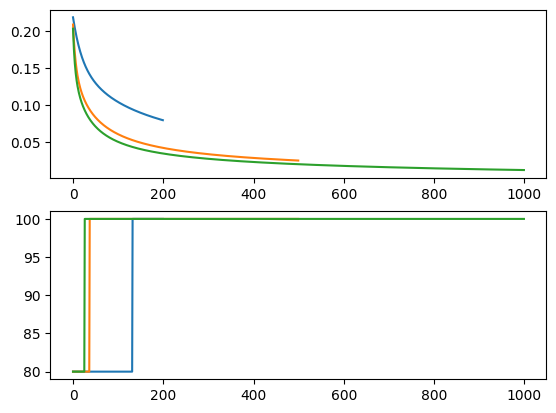

In [3]:
#Tests
X = np.arange(10).reshape(-1, 1)
T = np.array(['class1'] * 3 + ['class2'] * 4 + ['class3'] * 3).reshape(-1, 1)
n_inputs = X.shape[1]
model = LogisticRegression(n_inputs, ['class1', 'class2', 'class3'])
model.train(X, T, 200, 0.1)
Y_classes, Y = model.use(X)

plt.subplot(2, 1, 1)
plt.plot(model.mse_trace)
plt.subplot(2, 1, 2)
plt.plot(model.percent_correct_trace);

X = np.arange(10).reshape(-1, 1)
T = np.array(['class1'] * 3 + ['class2'] * 4 + ['class3'] * 3).reshape(-1, 1)
n_inputs = X.shape[1]
model = LogisticRegression(n_inputs, ['class1', 'class2', 'class3'])
model.train(X, T, 500, 0.35)
Y_classes, Y = model.use(X)

plt.subplot(2, 1, 1)
plt.plot(model.mse_trace)
plt.subplot(2, 1, 2)
plt.plot(model.percent_correct_trace);

X = np.arange(10).reshape(-1, 1)
T = np.array(['class1'] * 3 + ['class2'] * 4 + ['class3'] * 3).reshape(-1, 1)
n_inputs = X.shape[1]
model = LogisticRegression(n_inputs, ['class1', 'class2', 'class3'])
model.train(X, T, 1000, 0.5)
Y_classes, Y = model.use(X)

plt.subplot(2, 1, 1)
plt.plot(model.mse_trace)
plt.subplot(2, 1, 2)
plt.plot(model.percent_correct_trace);

In the tests above I ran the model three different times. With varying epochs (200-1000) and learning rates (0.1-0.5). Based on the graphs above it shows that as I increase the epochs and learning rate it seems like it takes longer and longer to get to 100% accuracy. So based on these tests it seams like there is an optimal value for the learning rate that will give you the fastest results.

##  <font color="red">**30 points**</font>: Experiment with Titanic Data



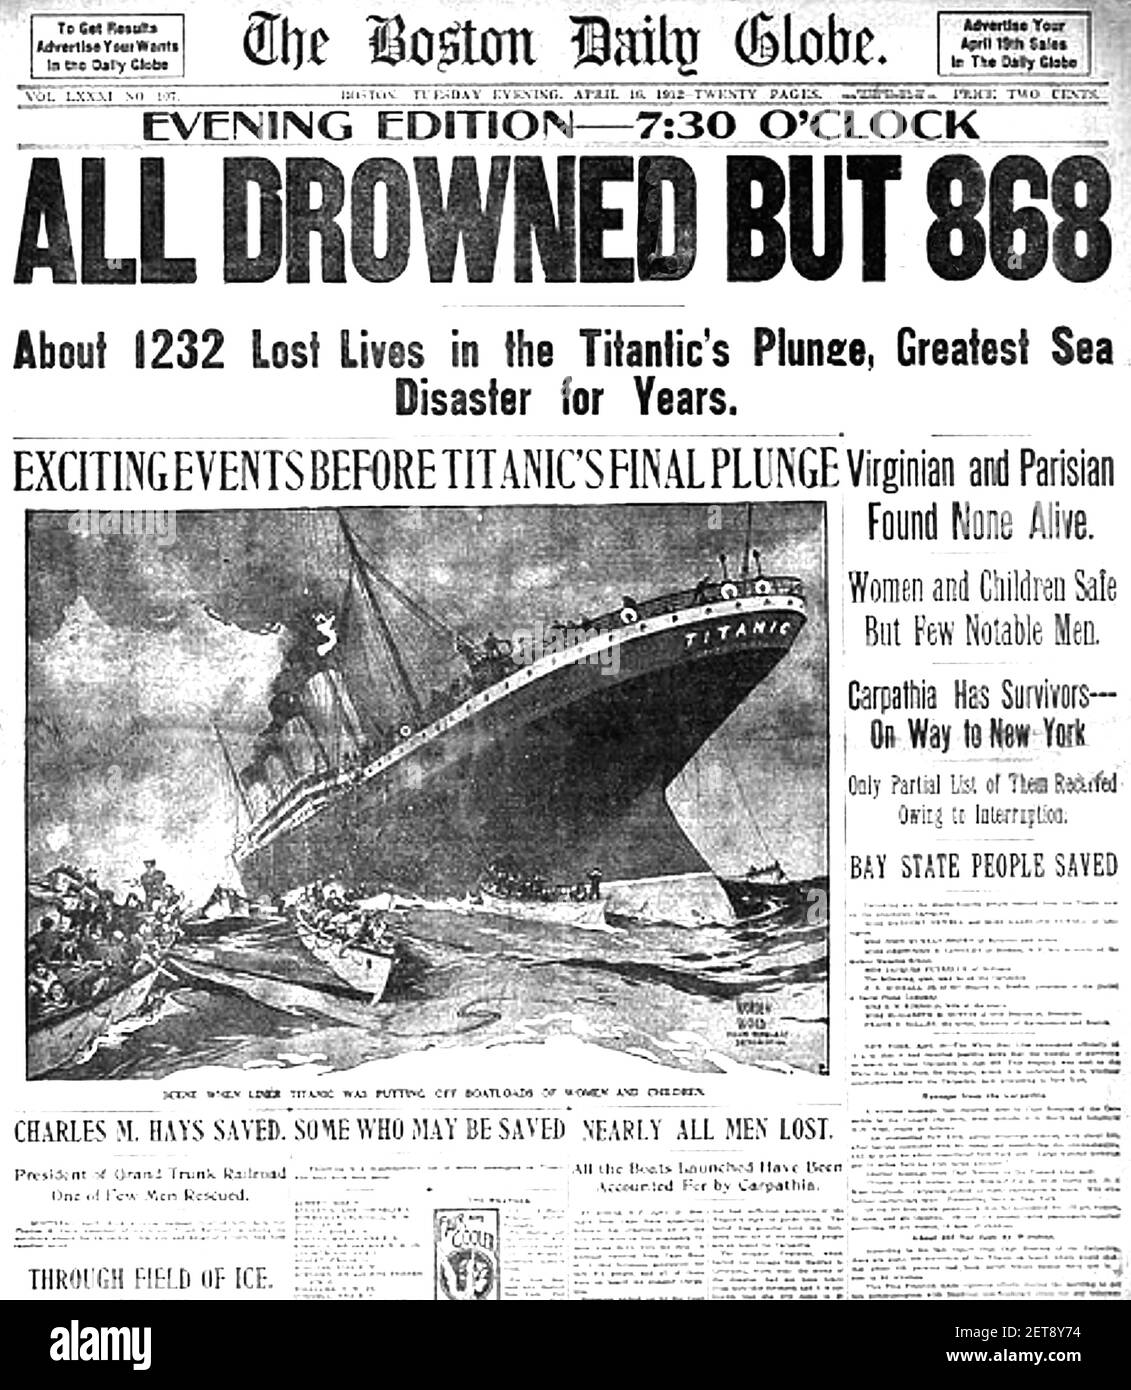



### Download and read the data

The titanic was a [luxurious passenger ship that sank in 1912](https://www.noaa.gov/gc-international-section/rms-titanic-history-and-significance#:~:text=Titanic%2C%20launched%20on%20May%2031,than%201%2C500%20passengers%20and%20crew.). 

The data in [titanic.csv](https://www.cs.colostate.edu/~anderson/cs345/notebooks/titanic.csv) is an often-used data set to demonstrate machine learning methods.

Read in the data and look at it.

In [4]:
df = pd.read_csv('titanic.csv')
df

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


### Create the `X` and `T` data matrices

Extract the input variables `['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']` into `numpy.array` $X$ by indexing into `df.

In [5]:
X_names = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']
X_names

['Pclass',
 'Sex',
 'Age',
 'Siblings/Spouses Aboard',
 'Parents/Children Aboard',
 'Fare']

In [6]:
X_df = df[X_names]
X_df

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,3,male,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...
882,2,male,27.0,0,0,13.0000
883,1,female,19.0,0,0,30.0000
884,3,female,7.0,1,2,23.4500
885,1,male,26.0,0,0,30.0000


We see that all of the attributes are numerical, except `Sex`. Let's use the `pandas` `replace` function to convert "male" to 0 and "female" to 1.

In [7]:
sex_to_int = {'male': 0, 'female':1}
sex_to_int

{'male': 0, 'female': 1}

In [8]:
X_df = X_df.replace({'Sex': sex_to_int})
X_df

/var/folders/5s/_68k3zsd12q1r1v36_nt1jsm0000gn/T/ipykernel_54990/1011899144.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df = X_df.replace({'Sex': sex_to_int})


,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,3,0,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,3,1,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...
882,2,0,27.0,0,0,13.0000
883,1,1,19.0,0,0,30.0000
884,3,1,7.0,1,2,23.4500
885,1,0,26.0,0,0,30.0000


In [9]:
X = X_df.values
X

array([[ 3.    ,  0.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 1.    ,  1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 3.    ,  1.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 3.    ,  1.    ,  7.    ,  1.    ,  2.    , 23.45  ],
       [ 1.    ,  0.    , 26.    ,  0.    ,  0.    , 30.    ],
       [ 3.    ,  0.    , 32.    ,  0.    ,  0.    ,  7.75  ]])

In [10]:
X.shape

(887, 6)

Now you write the code to extract "Survived" to form our target classes, $T$.

In [11]:
Survived = ['Survived']
T = df[Survived].values

In [12]:
T.shape

(887, 1)

In [13]:
T[:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]])

### Partition the data into train and test sets.

Okay. We have our data.  Let's randomly take 80% of the data for training and the remainder for testing.

In [14]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)

n_train = int(len(rows) * 0.8)
Xtrain = X[rows[:n_train]]
Ttrain = T[rows[:n_train]]

Xtest = X[rows[n_train:]]
Ttest = T[rows[n_train:]]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((709, 6), (709, 1), (178, 6), (178, 1))

### Train and test your LogisticRegression model on the Titanic data.

Now comes your time to code brilliantly!  Add code cells below to do these steps:

1. Create your model as an instance of your `LogisticRegression` class and assign the created instance to variable `model`.  You will have to pass arguments for the number of attributes in each sample (same as number of columns in `X`) and a list of the class names, which is just `[0, 1]` for our Titanic data.

2. Train your model using `Xtrain`, `Ttrain`, a number of epochs of 500, and a learning rate of 0.1.

3. Apply (use) your model to predict the classes of samples in `Xtest`.

4. Report the percent of test samples that were correctly classified.

5. Make a plot of the `mse_trace` available as an attribute of your model. Label each axis.

6. Make a plot of the `percent_correct_trace` available as an attribute of your model. Label each axis.

7. Describe in a markdown cell how well you think your model did in predicting who survived.

79.21348314606742


Text(0, 0.5, 'Percent Correct')

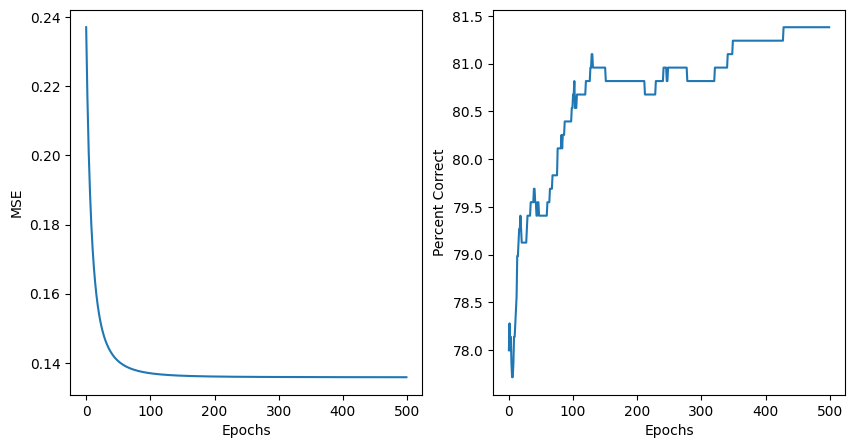

In [15]:
# Create instance of the LogisticRegression class
model = LogisticRegression(6, [0, 1])

# Train the model
model.train(Xtrain, Ttrain, 500, 0.1)

Y_classes, Y_softmax = model.use(Xtest)
print(model.percent_correct(Ttest, Y_classes))

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(model.mse_trace)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.subplot(1,2,2)
plt.plot(model.percent_correct_trace)
plt.xlabel('Epochs')
plt.ylabel('Percent Correct')

Are you wondering which of the sample attributes your model has found to be most influential on the predictions of who survived?  Your model's weights will reveal this, because we have standardized the inputs.

Here is some code that will create a bar graph of the weights

<BarContainer object of 7 artists>

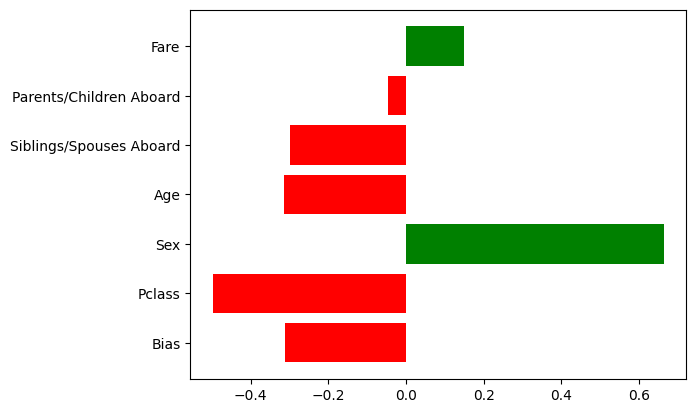

In [16]:
attribute_names = ['Bias'] + list(X_names)
colors = np.where(model.W[:, 1] >= 0, 'green', 'red')
plt.barh(attribute_names, model.W[:, 1], color=colors)    

Describe what you see in the bar graph.  Which attributes are most influential?  Do any of the signs surprise you?

According to this bar graph it seems like the cpatain of the ship prioritized women and children to get onto the life rafts first. As well as the poeple who paid more for their ticket were given priortity above those who didnt pay as much for their ticket. Overall based on the data I think that gender as well as ticket price played a considerable factor in if you survived the Titanic. In the future if a catastrophe like this were to happen again if you are a woman or a child or have paid more for your ticket I would bet that you have a higher chance of survival.